# Homework 5: taming text

In [1]:
import pandas as pd
import numpy as np
from os import path
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk import stem
import pycountry
import string

## Part 1: word clouds

We start by taking a look at the data

In [2]:
data = pd.read_csv("./hillary-clinton-emails/Emails.csv")
data.head()

,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,...,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
0,1,C05739545,WOW,H,"Sullivan, Jacob J",87.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545...,F-2015-04841,...,NaN,"Sullivan, Jacob J <Sullivan11@state.gov>",NaN,"Wednesday, September 12, 2012 10:16 AM",F-2015-04841,C05739545,05/13/2015,RELEASE IN FULL,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
1,2,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...",UNCLASSIFIED\nU.S. Department of State\nCase N...
2,3,C05739547,CHRIS STEVENS,;H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739547...,F-2015-04841,...,B6,"Mills, Cheryl D <MillsCD@state.gov>","Abedin, Huma","Wednesday, September 12, 2012 11:52 AM",F-2015-04841,C05739547,05/14/2015,RELEASE IN PART,Thx,UNCLASSIFIED\nU.S. Department of State\nCase N...
3,4,C05739550,CAIRO CONDEMNATION - FINAL,H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739550...,F-2015-04841,...,NaN,"Mills, Cheryl D <MillsCD@state.gov>","Mitchell, Andrew B","Wednesday, September 12,2012 12:44 PM",F-2015-04841,C05739550,05/13/2015,RELEASE IN PART,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
4,5,C05739554,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,"Abedin, Huma",H,80.0,2011-03-11T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739554...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739554,05/13/2015,RELEASE IN PART,"H <hrod17@clintonemail.com>\nFriday, March 11,...",B6\nUNCLASSIFIED\nU.S. Department of State\nCa...


We are only interested in the content of the email, in this case the ExtractedBodyText and the ExtractedSubject.

In [3]:
data.ExtractedBodyText = data.ExtractedBodyText.fillna('')
data.ExtractedSubject = data.ExtractedSubject.fillna('')
mails = pd.DataFrame(data.ExtractedSubject + " " + data.ExtractedBodyText)
mails.columns = ['content']
print(mails.size)
mails.head()

7945


,content
0,FW: Wow
1,"B6\nThursday, March 3, 2011 9:45 PM\nH: Lates..."
2,Re: Chris Stevens Thx
3,FVV: Cairo Condemnation - Final
4,"H <hrod17@clintonemail.com>\nFriday, March 11..."


For later tasks, we ran into problems with very big emails, so we thought of looking at the distribution of their sizes. They follow quite well a power law.

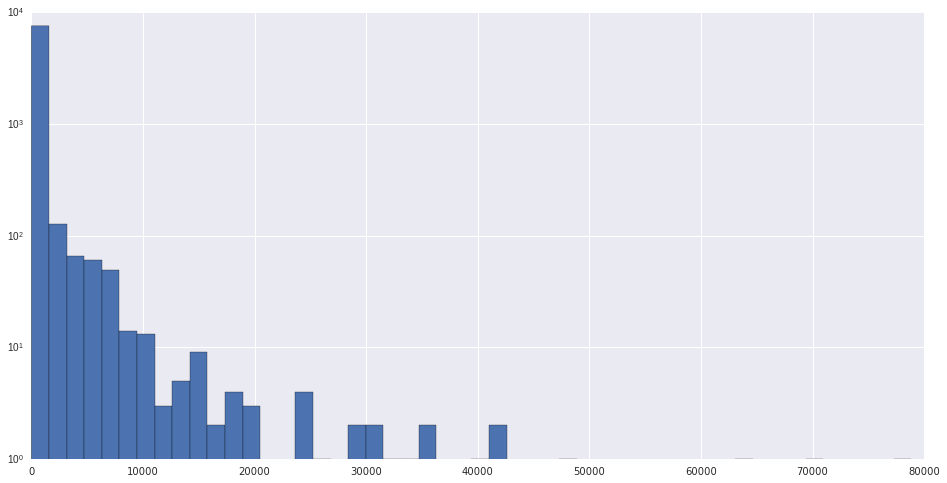

In [236]:
mails.content.str.len().hist(bins=50,figsize=(16,8)).set_yscale('log')

In order to create the first word cloud we need to concatenate all the email content together.

In [72]:
content = mails.content.str.cat(sep=' ')
content[0:100]

'FW: Wow   B6\nThursday, March 3, 2011 9:45 PM\nH: Latest How Syria is aiding Qaddafi and more... Sid\nh'

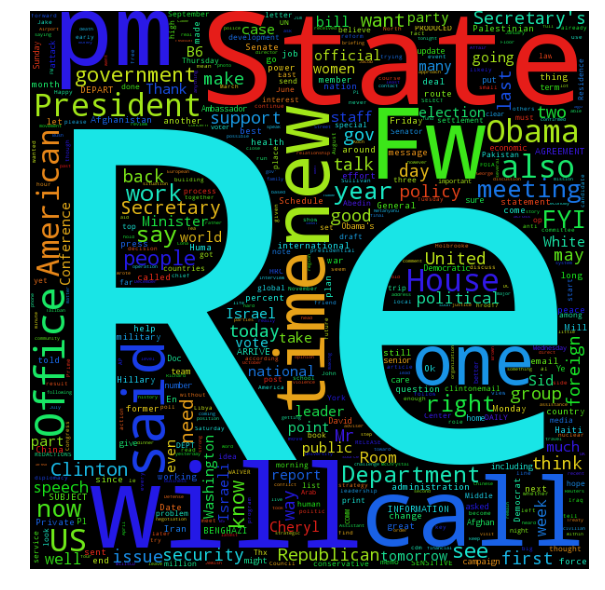

In [124]:
wordcloud = WordCloud(width=600, height=600, max_words=500)
wc_img = wordcloud.generate(content)

plt.subplots(figsize=(10,10))  # (10, 10) fits on my monitor
plt.imshow(wc_img)
plt.axis("off")
plt.show()

We will now pre-process the text in order to remove words such as re, fw, pm, new, also, many. This way our worldcloud will contain more useful words.

### Text pre-processing

We start by **tokenizing** the text. The regex tokenizer will also remove punctuation.

In [113]:
pattern = r'''(?x)          # set flag to allow verbose regexps
        (?:[A-Z]\.)+        # abbreviations, e.g. U.S.A.
      | \w+(?:-\w+)*        # words with optional internal hyphens
      | \$?\d+(?:\.\d+)?%?  # currency and percentages, e.g. $12.40, 82%
    '''
tokenizer = RegexpTokenizer(pattern)
tokens = tokenizer.tokenize(content)
print('.' in tokens or ',' in tokens or '(' in tokens) # no punctuation
print(len(tokens))

False
649810


We transform the tokens to all lowercase. US is exception, ofc

In [115]:
print('US' in tokens and 'U.S.' in tokens and 'U.S.A.' in tokens)

True


In [116]:
tokens = [x.lower() for x in tokens if x not in ['US', 'U.S.']]

Next we **remove stopwords**. This halves the data

In [117]:
stop = set(stopwords.words('english')) | set(['re', 'fw', 'pm', 'am', 'com'])
tokens = [word for word in tokens if word not in stop]
len(tokens)

375594

Next we apply **stemming**.

In [123]:
sno = stem.SnowballStemmer('english')
stems = [sno.stem(x) for x in tokens]

(-0.5, 599.5, 599.5, -0.5)

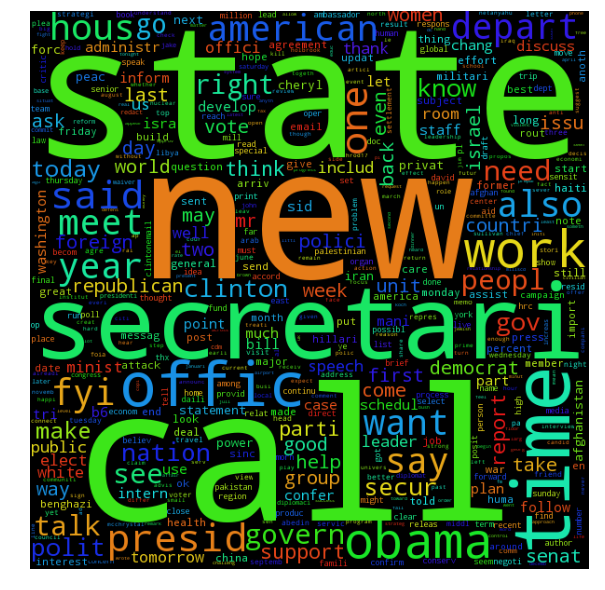

In [129]:
wc_img = wordcloud.generate(' '.join(stems))

plt.subplots(figsize=(10,10))
plt.imshow(wc_img)
plt.axis("off")

This word cloud contains stems instead of actual words (e.g. offic, secratari). We now try a **lemmatizer** instead of the stemmer.

In [126]:
lmtzr = stem.WordNetLemmatizer()
lemmas = [lmtzr.lemmatize(x) for x in tokens]
lemmas[0:10]

['wow', 'b6', 'thursday', 'march', '3', '2011', '9', '45', 'h', 'latest']

(-0.5, 599.5, 599.5, -0.5)

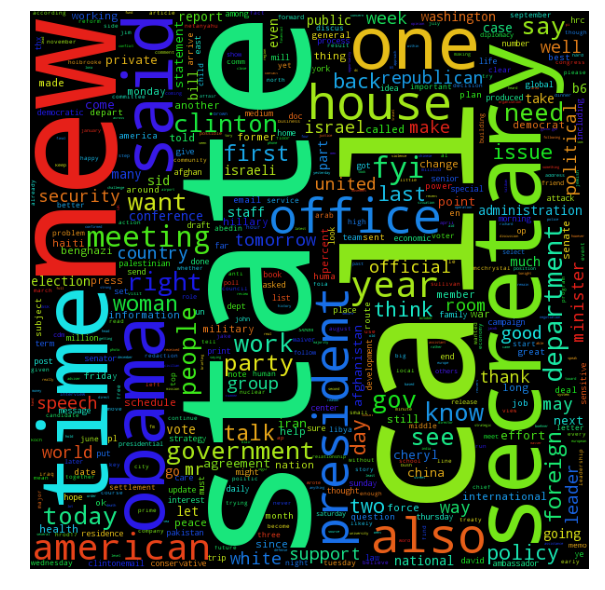

In [128]:
wc_img = wordcloud.generate(' '.join(lemmas))

plt.subplots(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis("off")

We conclude that the last wordcloud is the most interesting one because the text pre-processing removed some words that didn't bring any information. And it also grouped different uses of the same word as one.

## Part 2: Sentiment analysis for countries

Let's take a look at the countries that are provided with the pycountry library.

In [130]:
pycountry.countries.get(alpha_2='SY')

Country(alpha_2='SY', alpha_3='SYR', name='Syria', numeric='760')

We can see that this library will not do all the work for us. We need to figure out a way to go from 'Syrian Arab Republic' to 'Syria'. The same goes for 'Iran', 'Korea', 'Macedonia', 'Korea' and 'Tanzania'.

In [131]:
pycountry.countries.get(alpha_2='PM')

Country(alpha_2='PM', alpha_3='SPM', name='Saint Pierre and Miquelon', numeric='666')

We also need to be carefull with the use of the acronyms such as 'PM', 'AM', 'COM'. United kingdom should also be 'UK'.

We decide to make some changes to the provided library:
- 'Syrian Arab Republic' is changed to 'Syria'.
- whenever a country name contains a `","` with drop everything after `","`
- We add UK as an acronym for United Kingdom

In [132]:
countries = list(pycountry.countries)
for country in countries:
    if 'Syria' in country.name:
        country.name = 'Syria'
    if ',' in country.name:
        country.name = country.name.split(',', 1)[0]
    if country.alpha_3 == 'GBR':
        country.alpha_3 = 'UK'

We define a function that for each email content will match the content to the countries that are mentioned in the email. We add acronyms to the stopwords because this list will otherwise be identified with a country and we'd get a lot of false positives.

In [165]:
# sets are much faster for operation `in`
custom_stop  = set(stopwords.words('english'))

# add useless things from email and things which collide with country short codes
custom_stop |= set(['re', 'fw', 'pm', 'am', 'com', 'fm', 'om', 'mr', 'ms', 'st', 'ben', 'cc', 'tv', 'guy'])
# add special case for US, since we don't want to mistake it for `us` = you and me
custom_stop |= set(['us'])

In [179]:
t = set(['U.S.', 'Syria', 'U.K.', 'U.S.A.'])
t1 = set(map(lambda x: x if '.' not in x else ''.join(ch for ch in x if ch != '.'), t))

In [180]:
t1

{'Syria', 'UK', 'US', 'USA'}

In [181]:
def lookup_countries(content):
    """ Finds and returns all the countries mentioned in the content """
    
    # use tokens to check country code (UK, USA etc)
    # same tokenizer as above, also remove punctuation
    content_tok = tokenizer.tokenize(content)

    # remove stopwords and capitalise; put result in a set
    # be very careful about US; relies on lazy evaluation
    content_tok = {word.upper() for word in content_tok if word == 'US' or word.lower() not in custom_stop}

    # reduce abbreviations: U.S.A -> USA
    # because we work with sets rather lists, we have to do recreate the set
    content_tok = set(map(lambda tok: tok if   '.' not in tok 
                                          else ''.join(ch for ch in tok if ch != '.'), content_tok))
    
    
    # check if tokens correspond to countries
    present_countries = set()
    content = content.lower()  # to check for the name
    for country in countries:
        if   country.alpha_2 in content_tok \
          or country.alpha_3 in content_tok \
          or country.name.lower() in content:
            present_countries.add(country.name)
    
    if len(present_countries) > 0:
        return set(present_countries)
    return None  # no country found

In [182]:
lookup_countries('hello U.S.A., I am from Belgium and he is from Syria.')

{'Belgium', 'Syria', 'United States'}

In [183]:
lookup_countries("Us doesn't want that country") # -> None

In [184]:
lookup_countries("US is a country, though") # United States

{'United States'}

In [185]:
mails['countries'] = mails['content'].apply(lookup_countries)
mails.head(10)

,content,countries
0,FW: Wow,None
1,"B6\nThursday, March 3, 2011 9:45 PM\nH: Lates...","{Libya, Syria}"
2,Re: Chris Stevens Thx,None
3,FVV: Cairo Condemnation - Final,None
4,"H <hrod17@clintonemail.com>\nFriday, March 11...","{Libya, Syria}"
5,Meet The Right Wing Extremist Behind Anti-Musl...,{United States}
6,"FW: Anti-Muslim film director in hiding, follo...","{Libya, Egypt}"
7,"H <hrod17@clintonemail.corn>\nFriday, March 1...","{Libya, Syria}"
8,FVV: Secretary's remarks FYI,None
9,"more on Libya B6\nWednesday, September 12, 201...",{Libya}


In [186]:
mails.iloc[6].content

'FW: Anti-Muslim film director in hiding, following Libya, Egypt violence '

In [351]:
sum(mails.countries.isnull())

5578

In [352]:
mails_countries = mails[mails.countries.notnull()]
sum(mails_countries.countries.isnull())

0

Let's take a look at the countries that are mentioned in the emails.

In [353]:
all_countries = []
for c in mails_countries['countries']:
    all_countries.extend(c)
all_countries[:10]

['Libya',
 'Syria',
 'Libya',
 'Syria',
 'United States',
 'Libya',
 'Egypt',
 'Libya',
 'Syria',
 'Libya']

We remove all the countries that are mentioned less than 20 times

In [354]:
appearing_countries = pd.DataFrame(all_countries).groupby(0).size().rename('counts')
print(appearing_countries.size)
appearing_countries = appearing_countries[appearing_countries >= 20]
print(appearing_countries.size)

211
57


In [355]:
appearing_countries = pd.DataFrame(appearing_countries)
appearing_countries.index.name = 'CountryName'
appearing_countries

,counts
CountryName,
Afghanistan,144
Albania,72
Andorra,22
Angola,135
Argentina,23
Armenia,48
Australia,32
Brazil,53
Canada,35


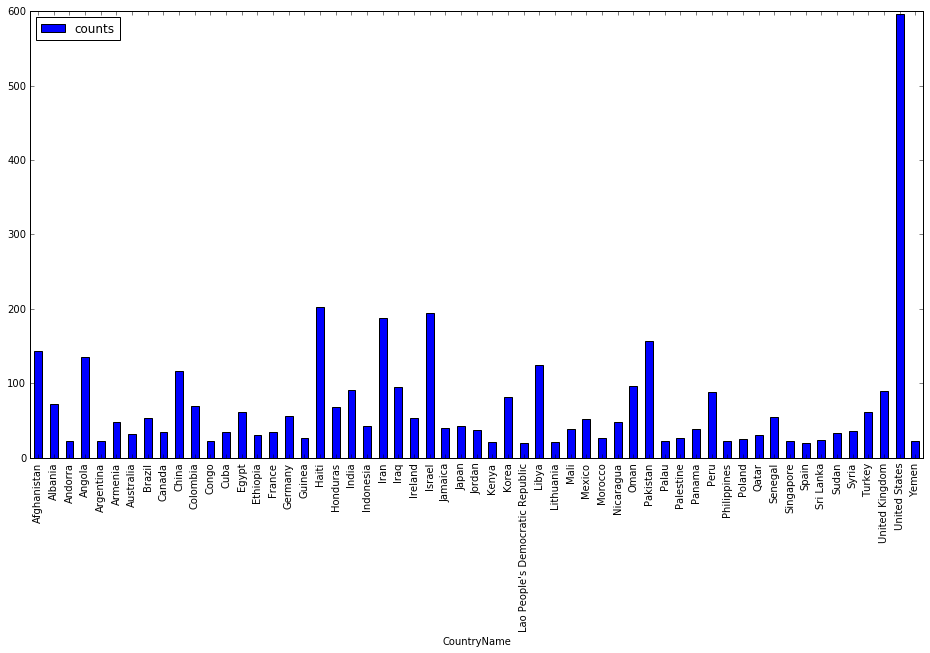

In [356]:
appearing_countries.plot(figsize=(16,8), kind='bar')

## Sentiment analysis

We propose 2 methods for analysing the sentiment in an email.
  - vocabulary count -- simply count how many positive vs negative words are in the content
  - VADER -- see their paper

In [357]:
from nltk.corpus import opinion_lexicon
print(opinion_lexicon.positive())

['a+', 'abound', 'abounds', 'abundance', 'abundant', ...]


The sneak peek above tells us that we do not need to apply stemming or lemming to use this lexicon

In [358]:
from nltk.tokenize.treebank import TreebankWordTokenizer
tokenizer = TreebankWordTokenizer()
puncts = set(string.punctuation)

In [359]:
print(tokenizer.tokenize("I didn't like the movie"))
print(tokenizer.tokenize("I can't suffer Sriracha"))

['I', 'did', "n't", 'like', 'the', 'movie']
['I', 'ca', "n't", 'suffer', 'Sriracha']


So if we don't mark the negative values, this analyser cannot differentiate between:

    I didn't like the movie
    I        like the movie

In [360]:
from nltk.tokenize.treebank import TreebankWordTokenizer
from nltk.sentiment.util import mark_negation
tokenizer = TreebankWordTokenizer()
puncts = set(string.punctuation)

# extract these in set as the stream operation is very costly; this brings a 10x speed improvement
pos_words = set([word for word in opinion_lexicon.positive()])
neg_words = set([word for word in opinion_lexicon.negative()])

def sentiment_lexicon(email):
    """ Analyzes sentence based on simple lexicon occurence count
        Returns { -1 | 0 | 1 }
    """
        
    tokens = [word.lower() for word in tokenizer.tokenize(email)]
    tokens_marked = mark_negation(tokens)
    
    value = 0
    for idx, word in enumerate(tokens):
        if word in puncts:
            continue
        if word in pos_words:
            if tokens_marked[idx].endswith("_NEG"):
                value -= 1
            else:
                value += 1
        elif word in neg_words:
            if tokens_marked[idx].endswith("_NEG"):
                value += 1
            else:
                value -= 1
    
    if value == 0:
        return value
    return value / abs(value)

In [361]:
# error check:
print(sentiment_lexicon("I like the movie"))
print(sentiment_lexicon("I didn't like the movie"))
print(sentiment_lexicon("The movie was OK"))

1.0
-1.0
0


In [362]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import tokenize
vader_analyser = SentimentIntensityAnalyzer()

def sentiment_vader(email):
    """ Computes the average VADER polarity for the sentences in the email.
        Returns float [-1, 1]
    """
    sentences = tokenize.sent_tokenize(email)
    polarity = 0.0
    for sentence in sentences:
        sent_polarity = vader_analyser.polarity_scores(sentence)["compound"]
        polarity += sent_polarity

    return polarity / len(sentences)

In [363]:
frequent_countries_set = set(appearing_countries.index)

In [364]:
def parse_lexicon(email_row):
    """ Computes the lexicon based polarity of the given row and accumulates it in 
        the relevant column of `appearing_countries`"""
    polarity = sentiment_lexicon(email_row.content)
    if polarity == 0: # nothing interesting
        return
    
    for country in email_row.countries:
        if country not in frequent_countries_set:
            continue
        if polarity > 0:
            appearing_countries.ix[country, 'pos_lexicon'] += 1
        else:
            appearing_countries.ix[country, 'neg_lexicon'] += 1

In [365]:
def parse_vader(email_row):
    """ Computes the VADER based polarity of the given row and accumulates it in 
        the relevant column of `appearing_countries`"""
#     print(email_row.name, end=' ') # progress track -- goes to 7938

    polarity = sentiment_vader(email_row.content)

    for country in email_row.countries:
        if country not in frequent_countries_set:
            continue
        if polarity > 0:
            appearing_countries.ix[country, 'pos_vader'] +=  polarity
        else:
            appearing_countries.ix[country, 'neg_vader'] += -polarity

email #214 , 4652 5287 5433 6257 takes very long. inspect why  -- they are VERY long (except for 219), with 30k, 40k and 70k characters and VADER is slow there

run #2 took 942 seconds 

Lexicon only run: 5 seconds

Vader only run: 933 seconds | 906 seconds without reinstantiating analyser

Vader averaging sentences: 24 seconds

In [366]:
import time
appearing_countries['pos_lexicon'] = 0
appearing_countries['neg_lexicon'] = 0

# very dangerous method: called on one object and modifies another !! 
# if you know of better way, please advise ! :)
duration = time.time()
mails_countries.apply(parse_lexicon, axis=1)
duration = time.time() - duration
print("Lexicon duration", duration)

Lexicon duration 5.444507837295532


In [367]:
appearing_countries['pos_vader'] = 0
appearing_countries['neg_vader'] = 0

# very dangerous method: called on one object and modifies another !! 
# if you know of better way, please advise ! :)
duration = time.time()
mails_countries.apply(parse_vader, axis=1)
duration = time.time() - duration
print("Vader duration", duration)

Vader duration 23.845181941986084


### Comparing sentiment analysis measures

We can now look at how each country is treated, in general, and according to the 2 proposed metrics (lexicon & VADER). We split them into 3 plots.

The `y` axis denotes how many emails fall into that category: positive or negative treatement, based on method. For a quantitative study, we would've only shown one measure at a time, but since we are comparing measures between them, we decided to show all scores.

In this way, we can note that in general, the 2 methods agree, i.e. when the `lexicon` thinks a country is usually spoken of in a more positive manner, so does `VADER`. [Note that the absolute differences between the 2 measures are irrelevant]

In [377]:
sum(    (appearing_countries.pos_lexicon > appearing_countries.neg_lexicon) \
     == (appearing_countries.pos_vader   > appearing_countries.neg_vader  ) \
   ) / len(appearing_countries)

0.84210526315789469

In numbers, the two methods agree 84% of the time. Caveat: this is on *cumulative* results, so the individual analysis per email could be wildly different.

We also note that `VADER` measure gives bigger relative differences. This could be due to the more exact scoring, with polarity of a text taking real values between `[-1, 1]`, as opposed to discrete `{-1, 1}` values in the case of `lexicon`

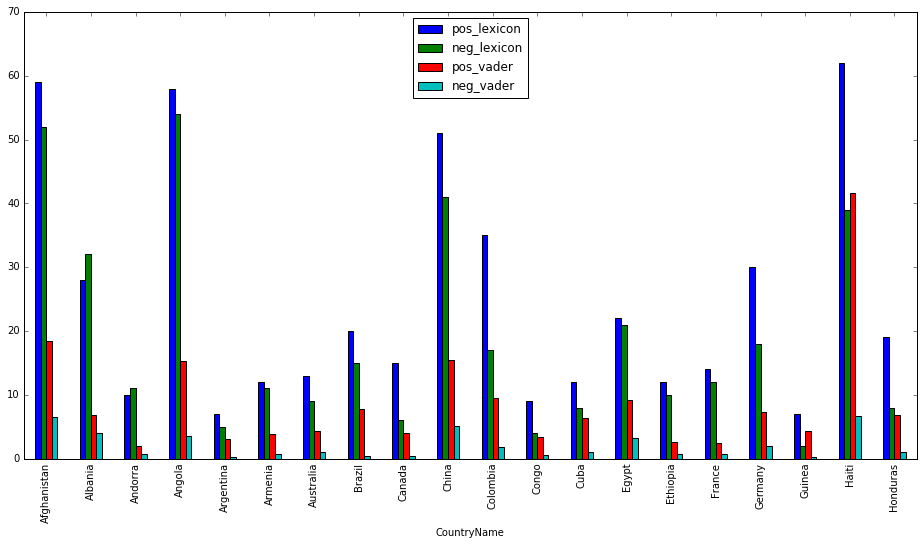

In [368]:
appearing_countries.ix[0:20, ['pos_lexicon', 'neg_lexicon', 'pos_vader', 'neg_vader']].plot.bar(figsize=(16,8))

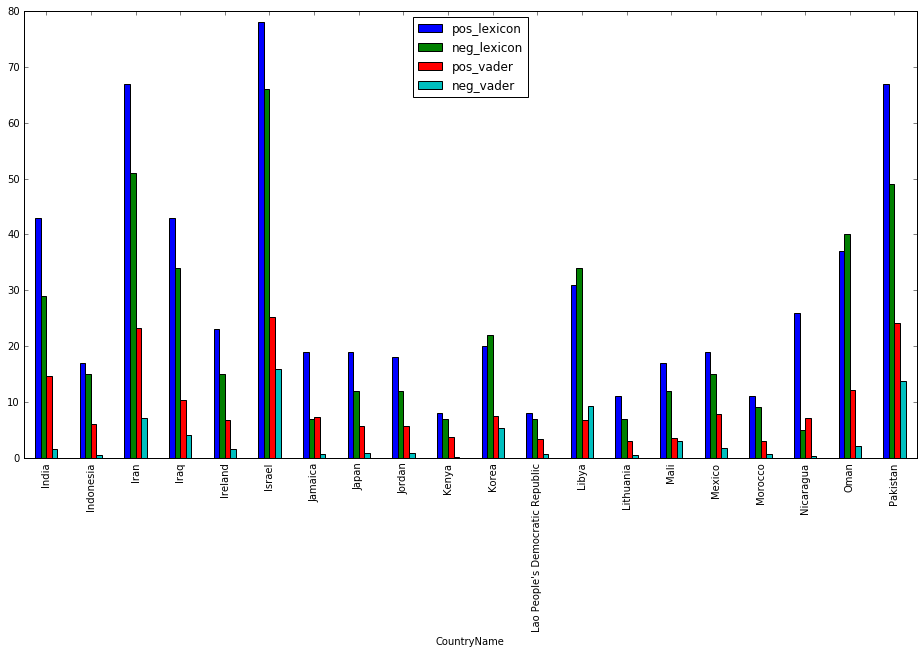

In [369]:
appearing_countries.ix[20:40, ['pos_lexicon', 'neg_lexicon', 'pos_vader', 'neg_vader']].plot.bar(figsize=(16,8))

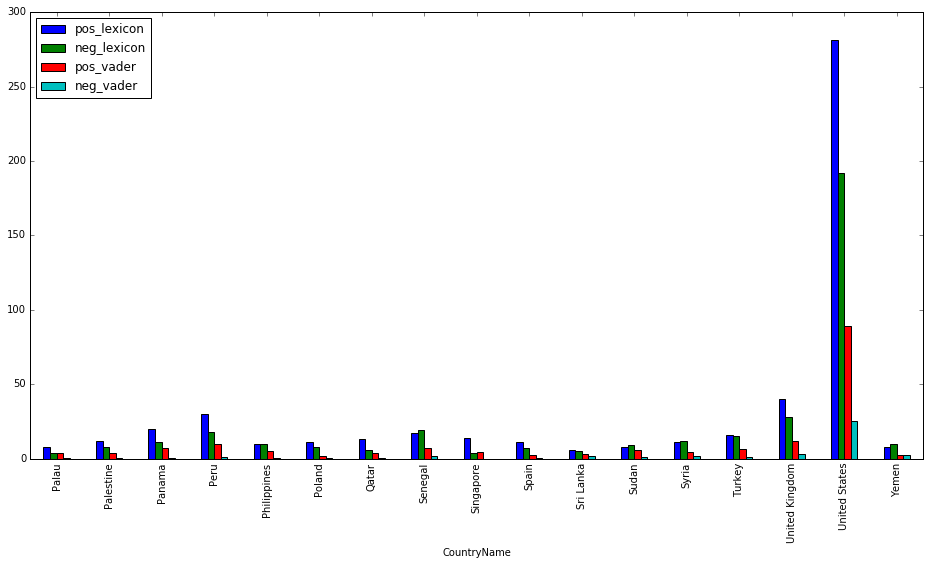

In [370]:
appearing_countries.ix[40:, ['pos_lexicon', 'neg_lexicon', 'pos_vader', 'neg_vader']].plot.bar(figsize=(16,8))